In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model

## Loading Data

In [3]:
def load_data():
    #first we load the MNIST dataset
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    #one hot vectorizing the labels
    Y_train_oneHot = tf.one_hot(Y_train, 10)
    Y_test_oneHot = tf.one_hot(Y_test, 10)
    
    #adding channel to the samples
    X_train_channeled = np.reshape(X_train, (X_train.shape[0], 
                                             X_train.shape[1], 
                                             X_train.shape[2], 1))
    X_test_channeled = np.reshape(X_test, (X_test.shape[0], 
                                            X_test.shape[1], 
                                            X_test.shape[2], 1))
    return X_train_channeled, X_test_channeled, Y_train_oneHot, Y_test_oneHot

## Generative Model Using Deep Convolutional Architecture

In [4]:
def generative_model():

    depth = 256
    generator_input = keras.Input(shape = (100), name = "Noise_Input")
    x = layers.Dense(7*7*256, name = "FullyConnected_Network_1")(generator_input)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_1")(x)
    x = layers.Activation("relu", name = "Relu_Activation_1")(x)

    x = layers.Reshape((7, 7, depth), name = "Reshaping_2")(x)
    x = layers.Dropout(0.4, name = "Inverse_Dropout_Regularizer_2")(x)

    
    x = layers.UpSampling2D(name = "Upsampling_3")(x)
    x = layers.Conv2DTranspose(int(depth/2), 5, padding = "same", name = "Conv_Layer_3")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_3")(x)
    x = layers.Activation("relu", name = "Relu_Activation_3")(x)

    
    x = layers.UpSampling2D(name = "UpSampling_4")(x)
    x = layers.Conv2DTranspose(int(depth/4), 5, padding = "same", name = "Conv_Layer_4")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_4")(x)
    x = layers.Activation("relu", name = "Relu_Activation_4")(x)

    
    x = layers.Conv2DTranspose(int(depth/8), 5, padding = "same", name = "Conv_Layer_5")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_5")(x)
    x = layers.Activation("relu", name = "Relu_Activation_5")(x)
    
    x = layers.Conv2DTranspose(1, 5, padding = "same", name = "1_Node_Output_6")(x)
    generator_output = layers.Activation("sigmoid", name = "Sigmoid_Activation_6")(x)
#     model.summary()
    
    return keras.Model(generator_input, generator_output, name = "Generator_Model")

Testing The Generator Function

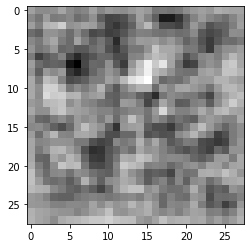

In [6]:
def generator_test():
    generator = generative_model()
    noise_input = np.random.normal(size = [1, 100])
    test_image = generator(noise_input, training=False)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test_image = sess.run(test_image)
    plt.imshow(test_image[0, :, :, 0], cmap='gray')

generator_test()

## Discriminative Model Using Deep Convolutional Architecture

In [7]:
def discriminative_model():
    depth = 64
    dropout = 0.4
    
#     input_shape = input_image_shape #it should be 28*28*1
    discriminator_input = keras.Input(shape = (28, 28, 1), name = "Image_Input")
    x = Conv2D(depth * 1, 5, strides = 2, padding = "same", name = "Conv_Layer_1")(discriminator_input)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_1")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_1")(x)

    x = layers.Conv2D(depth * 2, 5, strides = 2, padding = "same", name = "Conv_Layer_2")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_2")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_2")(x)

    x = layers.Conv2D(depth * 4, 5, strides = 2, padding = "same", name = "Conv_Layer_3")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_3")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_3")(x)

    x = layers.Conv2D(depth * 8, 5, strides = 1, padding = "same", name = "Conv_Layer_4")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_4")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_4")(x)    

    x = layers.Flatten(name = "FullyConnected_Network_5")(x)
    x = layers.Dense(1, name = "1_Node_Output_5")(x)
    discriminator_output = layers.Activation("sigmoid", name = "Sigmoid_Activation_5")(x)

    return keras.Model(discriminator_input, discriminator_output, name = "Discriminator_Model")

In [8]:
def discriminator_test():
    generator = generative_model()
    noise_input = np.random.normal(size = [1, 100])
    test_image = generator(noise_input, training=False)
    discriminator = discriminative_model()
    output_class = discriminator(test_image, training=False)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test_image = sess.run(test_image)
        output_class = sess.run(output_class)
    print(output_class)

discriminator_test()

[[0.5001882]]


## Adding Discriminator and Adversarial Loss 

In [14]:
def discriminator_loss():
    discriminator_model = discriminative_model()
    discriminator = keras.models.Sequential()
    discriminator.add(discriminator_model)
    discriminator_model.summary()
    print("\n\n\n")
    discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0002, 
                                                       decay=6e-8)
    
    discriminator.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                          optimizer = discriminator_optimizer, 
                          metrics = ["accuracy"])
    return discriminator, discriminator_model

def generator_loss(discriminator):
    generator_model = generative_model()
    generator_model.summary()
    print("\n\n\n")
    
    generator_input = keras.Input(shape = (100), name = "Noise_Input")
    generator_to_discriminator = generator_model(generator_input)
    attaching_discriminator = discriminator(generator_to_discriminator)
    attached_model = keras.Model(generator_input, attaching_discriminator, name = "Adversarial_Model")
    attached_model.summary()
    print("\n\n\n")
    generator_optimizer = keras.optimizers.RMSprop(lr=0.0002,
                                                   decay=3e-8)

    attached_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                           optimizer = generator_optimizer, 
                           metrics = ["accuracy"])
    return attached_model, generator_model

## Preparing The Models

In [15]:
discriminator_compilation, discriminator_model = discriminator_loss()
generator_compilation, generator_model = generator_loss(discriminator_model)

Model: "Discriminator_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_Layer_1 (Conv2D)        (None, 14, 14, 64)        1664      
_________________________________________________________________
LeakyRelu_Activation_1 (Leak (None, 14, 14, 64)        0         
_________________________________________________________________
Inverse_Dropout_Regularizer_ (None, 14, 14, 64)        0         
_________________________________________________________________
Conv_Layer_2 (Conv2D)        (None, 7, 7, 128)         204928    
_________________________________________________________________
LeakyRelu_Activation_2 (Leak (None, 7, 7, 128)         0         
_________________________________________________________________
Inverse_Dropout_Regularizer_ (None, 7, 7, 128) 

## The Discriminator Model

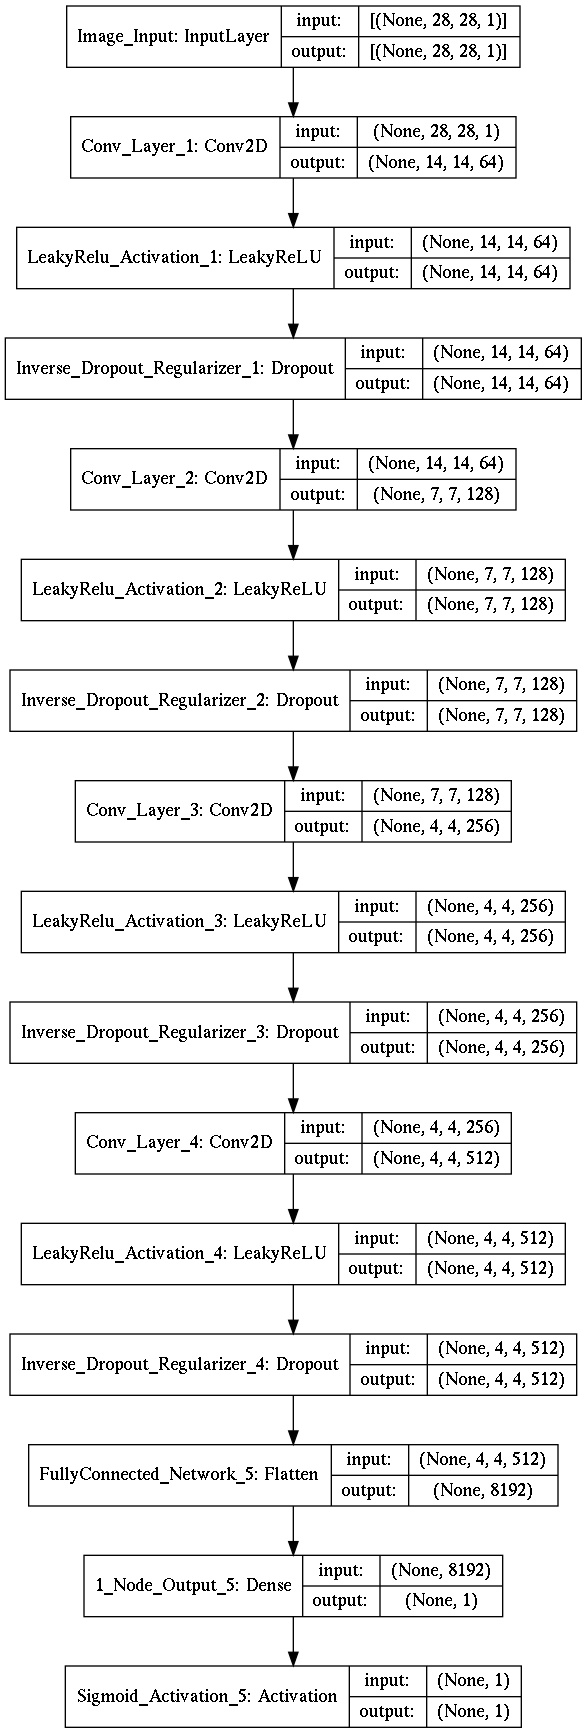

In [12]:
keras.utils.plot_model(discriminator_model, show_shapes=True)

## The Generator Model 

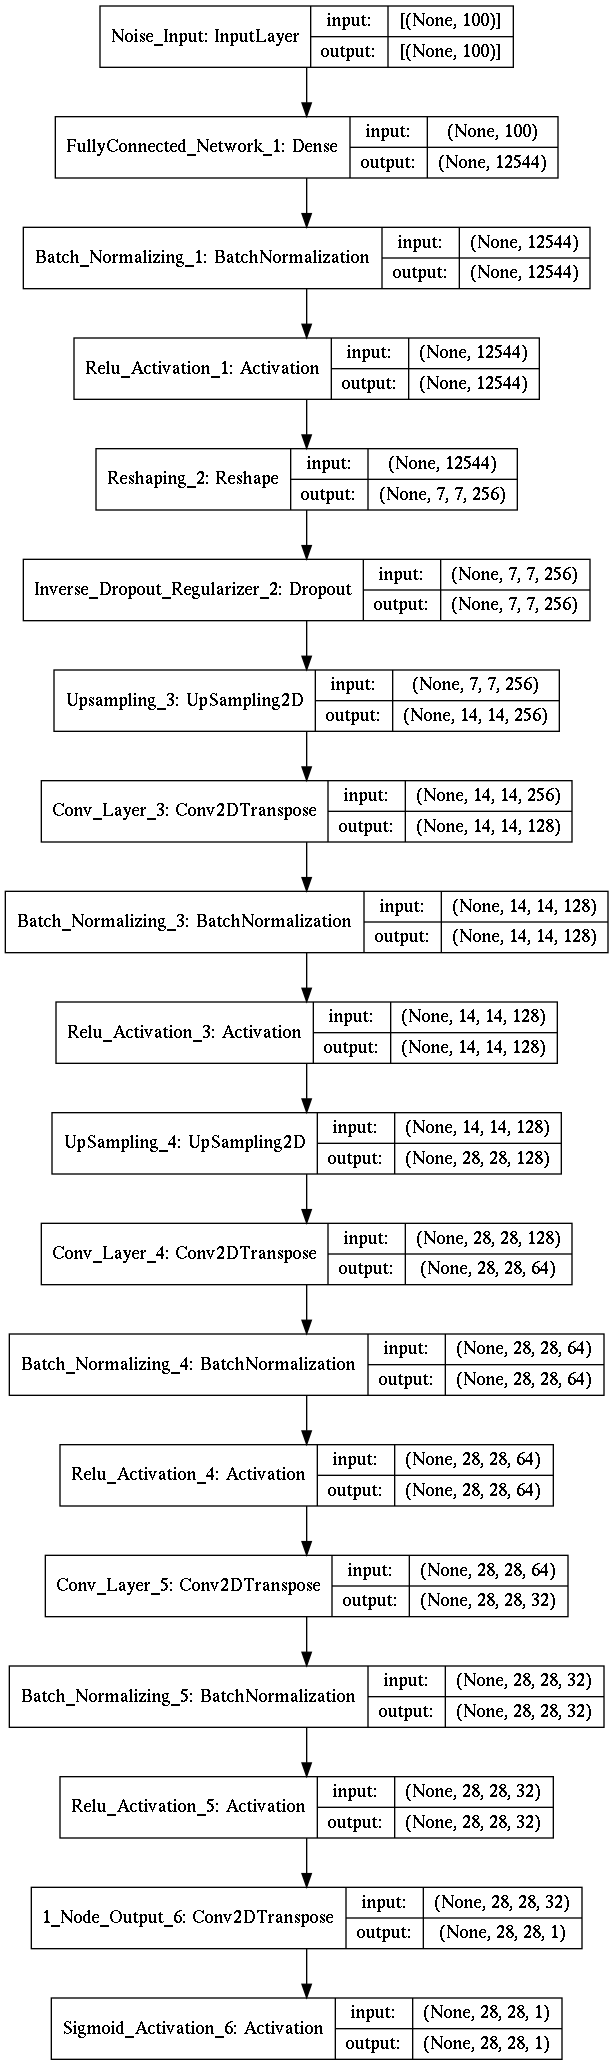

In [13]:
keras.utils.plot_model(generator_model, show_shapes=True)

## The Adversarial Model 

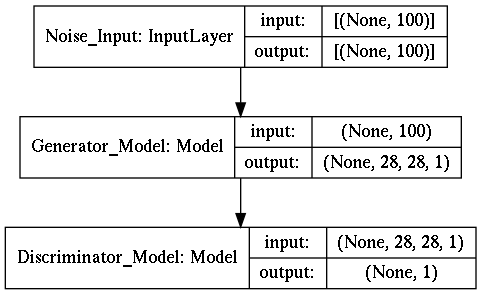

In [16]:
keras.utils.plot_model(generator_compilation, show_shapes=True)

## Running The Optimization

We run discriminator optimization 5 times more as it is the upper bound of the adversarial optimization (GAN paper for more information). In DCGAN paper it was not mandatory, but in this experiment based on used hyperparameters the discriminator was limitting the adversarial network optimization.

'epoch:  0 ' [discriminator loss:  2.0494578  and acc:  0.41992188 ] [generator loss:  0.40555966  and acc:  1.0 ]


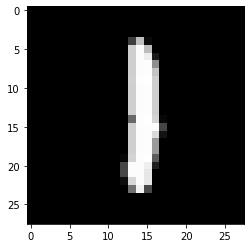

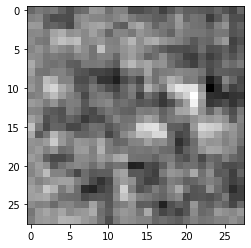

'epoch:  1 ' [discriminator loss:  3.3749008  and acc:  0.5 ] [generator loss:  0.05748543  and acc:  1.0 ]
'epoch:  2 ' [discriminator loss:  2.6195552  and acc:  0.5 ] [generator loss:  0.012863504  and acc:  1.0 ]
'epoch:  3 ' [discriminator loss:  1.7152789  and acc:  0.5 ] [generator loss:  0.017046714  and acc:  1.0 ]
'epoch:  4 ' [discriminator loss:  1.5457103  and acc:  0.5 ] [generator loss:  0.010878293  and acc:  1.0 ]
'epoch:  5 ' [discriminator loss:  1.2517089  and acc:  0.5 ] [generator loss:  0.008434978  and acc:  1.0 ]
'epoch:  6 ' [discriminator loss:  1.0267277  and acc:  0.5 ] [generator loss:  0.0055370126  and acc:  1.0 ]
'epoch:  7 ' [discriminator loss:  0.83215964  and acc:  0.5 ] [generator loss:  0.0040417034  and acc:  1.0 ]
'epoch:  8 ' [discriminator loss:  0.7006602  and acc:  0.5 ] [generator loss:  0.0027156933  and acc:  1.0 ]
'epoch:  9 ' [discriminator loss:  0.59960127  and acc:  0.5 ] [generator loss:  0.0022752932  and acc:  1.0 ]
'epoch:  10 ' 

'epoch:  75 ' [discriminator loss:  2.8005438  and acc:  0.5 ] [generator loss:  0.06883289  and acc:  1.0 ]
'epoch:  76 ' [discriminator loss:  2.8138733  and acc:  0.5 ] [generator loss:  0.06448058  and acc:  1.0 ]
'epoch:  77 ' [discriminator loss:  2.7004547  and acc:  0.5 ] [generator loss:  0.0673757  and acc:  1.0 ]
'epoch:  78 ' [discriminator loss:  2.70725  and acc:  0.5 ] [generator loss:  0.063858114  and acc:  1.0 ]
'epoch:  79 ' [discriminator loss:  2.6337638  and acc:  0.5 ] [generator loss:  0.06704298  and acc:  1.0 ]
'epoch:  80 ' [discriminator loss:  2.636951  and acc:  0.5 ] [generator loss:  0.06523967  and acc:  1.0 ]
'epoch:  81 ' [discriminator loss:  2.556241  and acc:  0.5 ] [generator loss:  0.06256973  and acc:  1.0 ]
'epoch:  82 ' [discriminator loss:  2.5062985  and acc:  0.5 ] [generator loss:  0.066279545  and acc:  1.0 ]
'epoch:  83 ' [discriminator loss:  2.5125823  and acc:  0.5 ] [generator loss:  0.062469594  and acc:  1.0 ]
'epoch:  84 ' [discri

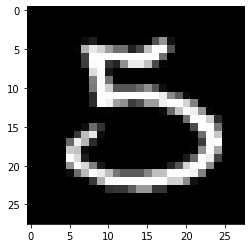

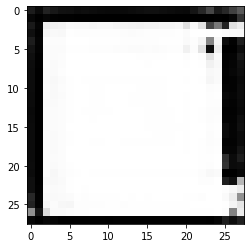

'epoch:  101 ' [discriminator loss:  2.1390233  and acc:  0.5 ] [generator loss:  0.059439864  and acc:  1.0 ]
'epoch:  102 ' [discriminator loss:  2.1174338  and acc:  0.5 ] [generator loss:  0.0578116  and acc:  1.0 ]
'epoch:  103 ' [discriminator loss:  2.099517  and acc:  0.5 ] [generator loss:  0.05928188  and acc:  1.0 ]
'epoch:  104 ' [discriminator loss:  2.1096025  and acc:  0.5 ] [generator loss:  0.05757142  and acc:  1.0 ]
'epoch:  105 ' [discriminator loss:  2.0990167  and acc:  0.5 ] [generator loss:  0.05834834  and acc:  1.0 ]
'epoch:  106 ' [discriminator loss:  2.0690572  and acc:  0.5 ] [generator loss:  0.057916097  and acc:  1.0 ]
'epoch:  107 ' [discriminator loss:  2.0788777  and acc:  0.5 ] [generator loss:  0.059641454  and acc:  1.0 ]
'epoch:  108 ' [discriminator loss:  2.0992785  and acc:  0.5 ] [generator loss:  0.057624012  and acc:  1.0 ]
'epoch:  109 ' [discriminator loss:  2.0767004  and acc:  0.5 ] [generator loss:  0.05793412  and acc:  1.0 ]
'epoch: 

In [ ]:
noise_dim = 1
epoch_num = 4000
batch_size = 256
X_train, X_test, Y_train, Y_test = load_data()

d_loss_tracker = []
g_loss_tracker = []
d_acc_tracker = []
g_acc_tracker = []

for epoch in range(epoch_num):
    noise_input = np.random.uniform(-1, 1, size = [batch_size, 100])
    fake_images = generator_model.predict(noise_input)

    for discriminator_epochs in range(1):
        genuine_images = X_train[np.random.randint(
            0, X_train.shape[0], size = batch_size), :, :, :]
        
        X_input = np.concatenate((genuine_images, fake_images))
        Y_label = np.ones([2 * batch_size, 1])
        Y_label[batch_size : , : ] = 0 

        d_loss = discriminator_compilation.train_on_batch(X_input, Y_label)
    
    Y_label = np.ones([batch_size, 1])
    g_loss = generator_compilation.train_on_batch(noise_input, Y_label)
    print("\'epoch: ", epoch,"\' [discriminator loss: ", d_loss[0], " and acc: ", d_loss[1],"] [generator loss: ",
          g_loss[0]," and acc: ", g_loss[1],"]")

    d_loss_tracker.append(d_loss[0])
    g_loss_tracker.append(g_loss[0])
    d_acc_tracker.append(d_loss[1])
    g_acc_tracker.append(g_loss[1])
    
    if epoch % 100 == 0:
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(genuine_images[0, :, :, 0], cmap='gray')
        plt.show()
        plt.imshow(fake_images[0, :, :, 0], cmap='gray')
        plt.show()